In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
plt.style.use("seaborn-v0_8")

In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("global_electricity_production_data.csv")
df.head()

Saving global_electricity_production_data.csv to global_electricity_production_data.csv


,country_name,date,parameter,product,value,unit
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.9356,GWh
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.5223,GWh
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.5415,GWh
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.9272,GWh


In [ ]:
df = df.dropna(subset=["value"])
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [ ]:
df["parameter"] == "Net Electricity Production"

,parameter
0,True
1,True
2,True
3,True
4,True
...,...
121069,False
121070,False
121071,False
121072,False


Only rows with valid production values and correct dates are useful for analyzing trends. We want to focus on actual electricity production, not imports/exports/losses.



/tmp/ipython-input-738477116.py:9: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


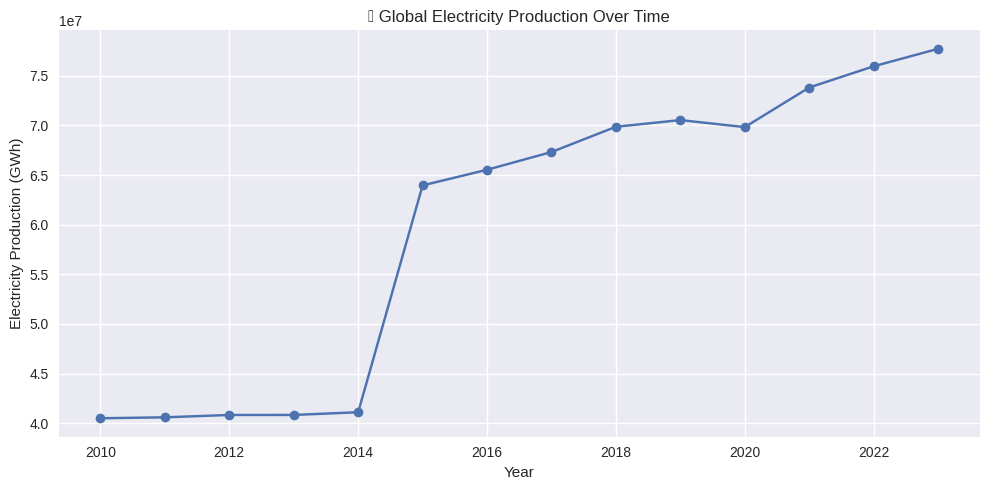

In [ ]:
global_trend = df.groupby("year")["value"].sum()

plt.figure(figsize=(10, 5))
global_trend.plot(marker='o')
plt.title("🌍 Global Electricity Production Over Time")
plt.xlabel("Year")
plt.ylabel("Electricity Production (GWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
top5_countries = (
    df.groupby("country_name")["value"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

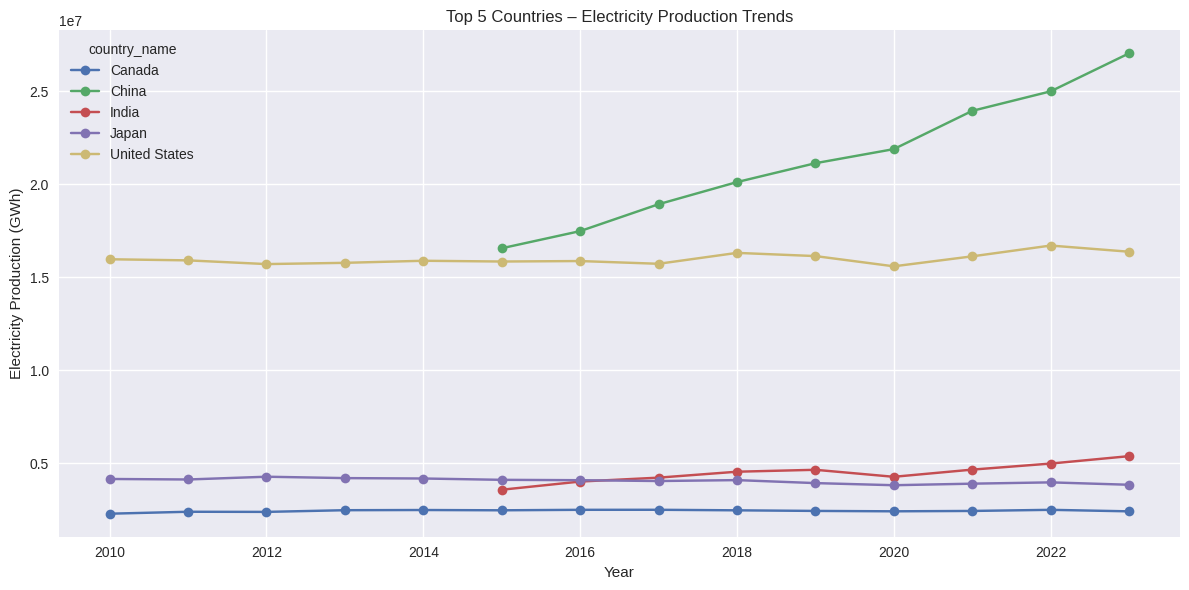

In [ ]:
top5_df = df[df["country_name"].isin(top5_countries)]
top5_yearly = top5_df.groupby(["year", "country_name"])["value"].sum().unstack()

top5_yearly.plot(marker='o', figsize=(12, 6))
plt.title("Top 5 Countries – Electricity Production Trends")
plt.xlabel("Year")
plt.ylabel("Electricity Production (GWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

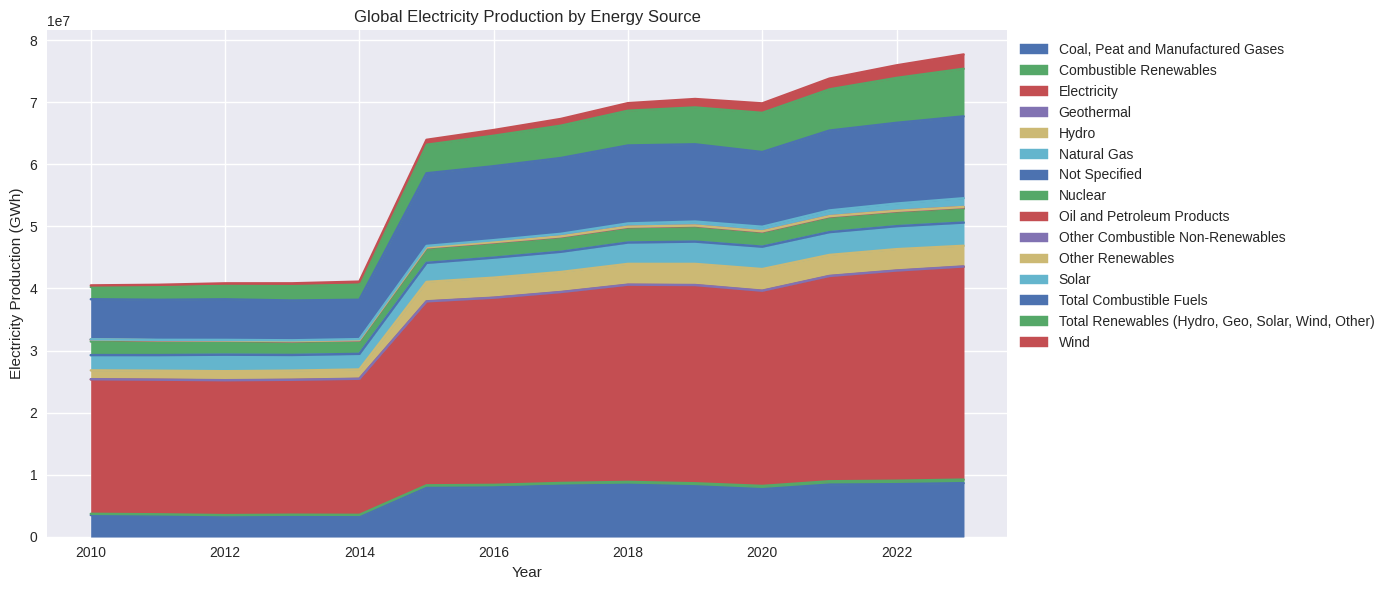

In [ ]:
source_mix = df.groupby(["year", "product"])["value"].sum().unstack().fillna(0)

source_mix.plot.area(figsize=(14, 6), stacked=True)
plt.title("Global Electricity Production by Energy Source")
plt.xlabel("Year")
plt.ylabel("Electricity Production (GWh)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

# 0) Make sure the columns exist and are the right types
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# 1) Ensure we have a proper datetime column and a YEAR column
if "year" not in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year

# 2) Drop rows we can't use
df = df.dropna(subset=["value", "year"])


Top 3 products globally: ['Electricity', 'Total Combustible Fuels', 'Coal, Peat and Manufactured Gases']


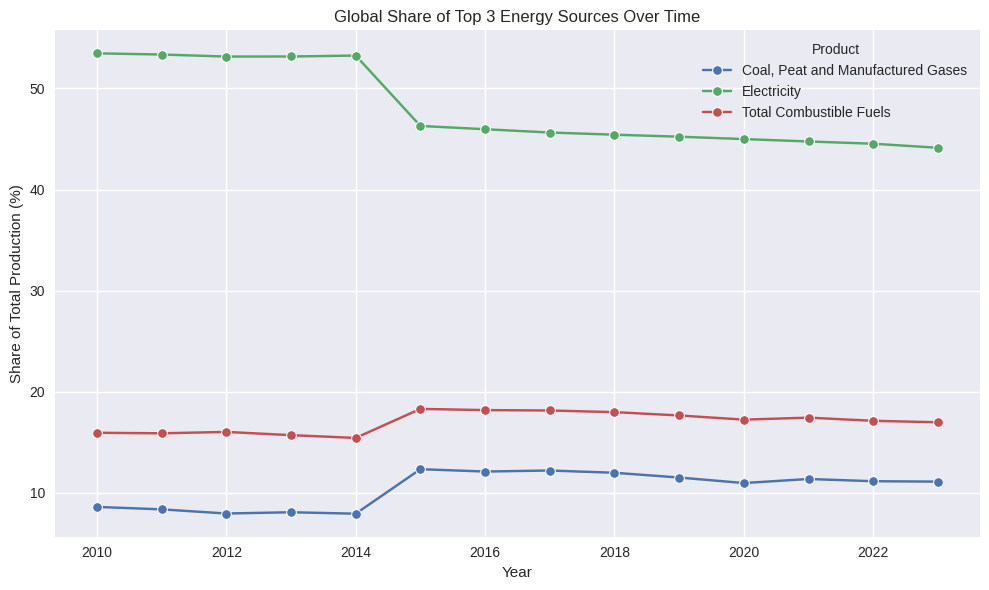

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- A) (Optional but recommended) exclude aggregate labels like "Electricity" or "Total ..."
# If you want only real sources (coal, gas, solar, wind...), uncomment this:
# mask_real_sources = ~df["product"].str.contains(r"^Total|^Electricity$", case=False, na=False)
# df_sources = df[mask_real_sources].copy()
# If you want to keep everything as-is, just use the line below instead:
df_sources = df.copy()

# --- B) Top 3 products globally (sum over all years)
total_by_product = (
    df_sources.groupby("product")["value"]
    .sum()
    .sort_values(ascending=False)
)
top3_products = total_by_product.head(3).index.tolist()
print("Top 3 products globally:", top3_products)

# --- C) Filter to those top 3 and compute yearly shares
df_top3 = df_sources[df_sources["product"].isin(top3_products)].copy()

yearly_totals = (
    df_top3.groupby(["year", "product"])["value"]
    .sum()
    .reset_index()
)

# total per year across the 3 products (for % share of the whole power system,
# divide by TOTAL production per year across ALL products instead)
total_per_year_all = (
    df.groupby("year")["value"]
    .sum()
    .rename("total_value_all")
    .reset_index()
)

yearly_totals = yearly_totals.merge(total_per_year_all, on="year", how="left")
yearly_totals["share_percent"] = (
    yearly_totals["value"] / yearly_totals["total_value_all"] * 100
)

# --- D) Plot: share of top 3 products over time
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=yearly_totals,
    x="year",
    y="share_percent",
    hue="product",
    marker="o"
)
plt.title("Global Share of Top 3 Energy Sources Over Time")
plt.xlabel("Year")
plt.ylabel("Share of Total Production (%)")
plt.grid(True)
plt.legend(title="Product")
plt.tight_layout()
plt.show()
